<h1 style="text-align: center;">DATA 255 - Fall24 - Group Project</h1>

<h2 style="text-align: center;"> Pneumonia Detection using chest X-Ray and Deep Learning Technologies

## 1. Importing necessary libraries

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import transforms
import shutil
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from torchvision import models
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize














In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

## 2. Loading and Exploring the data

#### <b> 2.1. Importing train, Validation and test Dataset, and exploring the classes of images

In [2]:
# Define paths
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize to 150x150
    transforms.ToTensor(),         # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to range [-1, 1]
])

# Load the datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class mappings (optional, to verify classes)
class_names = train_dataset.classes
print("Class Names:", class_names)


Class Names: ['NORMAL', 'PNEUMONIA']


#### <b> 2.2. How many images present in the train, Validation and test Dataset

In [3]:
# Count images in each dataset
train_total = len(train_dataset)
val_total = len(val_dataset)
test_total = len(test_dataset)

# Calculate ratios
total_images = train_total + val_total + test_total
train_ratio = train_total / total_images
val_ratio = val_total / total_images
test_ratio = test_total / total_images

# Print results
print(f"Total Images: {total_images}")
print(f"Training Set: {train_total} images ({train_ratio:.2%} of total)")
print(f"Validation Set: {val_total} images ({val_ratio:.2%} of total)")
print(f"Test Set: {test_total} images ({test_ratio:.2%} of total)")


Total Images: 5856
Training Set: 5216 images (89.07% of total)
Validation Set: 16 images (0.27% of total)
Test Set: 624 images (10.66% of total)


#### Validation Set: Contains only 16 images, accounting for just 0.27% of the total dataset. This is unusually small for a validation set, which might lead to unreliable performance evaluation during training.

#### Here we see that the dataset split is not proper

#### <b> 2.3. Visually showing how many images present in the train, Validation and test Dataset

Train Class Distribution: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation Class Distribution: {'NORMAL': 8, 'PNEUMONIA': 8}
Test Class Distribution: {'NORMAL': 234, 'PNEUMONIA': 390}


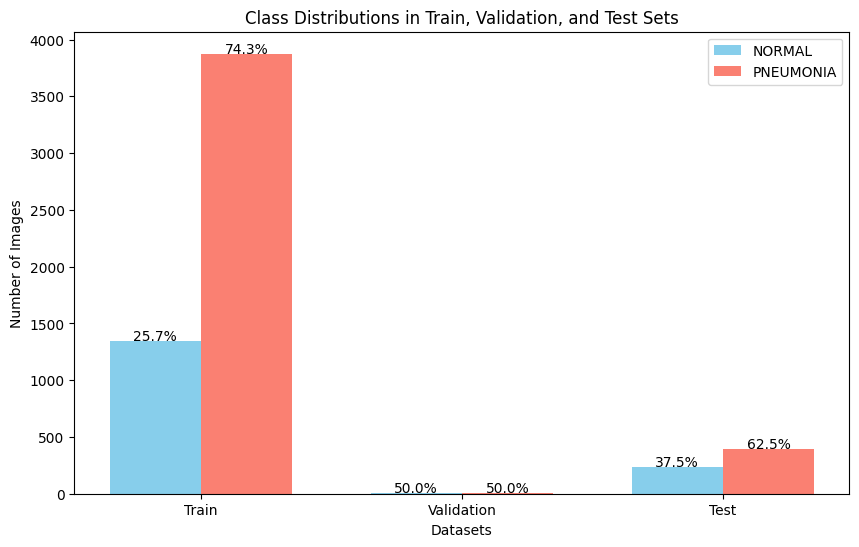

In [4]:
# Count images for each class
def count_images_per_class(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Get class distributions
train_counts = count_images_per_class(train_dataset)
val_counts = count_images_per_class(val_dataset)
test_counts = count_images_per_class(test_dataset)

# Print distributions
print("Train Class Distribution:", train_counts)
print("Validation Class Distribution:", val_counts)
print("Test Class Distribution:", test_counts)

# Visualization
datasets_names = ['Train', 'Validation', 'Test']
class_labels = train_dataset.classes  # Classes from ImageFolder

# Prepare data for plotting
data = [
    [train_counts[class_labels[0]], train_counts[class_labels[1]]],
    [val_counts[class_labels[0]], val_counts[class_labels[1]]],
    [test_counts[class_labels[0]], test_counts[class_labels[1]]],
]

# Calculate total images in each dataset
totals = [sum(d) for d in data]

# Plot bar chart
x = range(len(datasets_names))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
for i, bars in enumerate([bars1, bars2]):  # Loop through NORMAL and PNEUMONIA bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, f'{percent:.1f}%', 
                 ha='center', fontsize=10)

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets_names)
plt.legend()
plt.show()


## 3. Preprocessing the Data 

#### <b> 3.1. Data Redistribution for Chest X-Ray Pneumonia Dataset

In [5]:
# Paths to original directories
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# New directories for redistributed data
base_dir = '/kaggle/working/chest_xray_redistributed'
train_new_dir = os.path.join(base_dir, 'train')
val_new_dir = os.path.join(base_dir, 'val')
test_new_dir = os.path.join(base_dir, 'test')

# Create new directories
os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_new_dir, exist_ok=True)
os.makedirs(test_new_dir, exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(train_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_new_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_new_dir, cls), exist_ok=True)

# Function to gather all images in a directory structure
def get_all_images(directory, class_name):
    full_path = os.path.join(directory, class_name)
    return [os.path.join(full_path, fname) for fname in os.listdir(full_path) if fname.endswith(('.png', '.jpg', '.jpeg'))]

# Gather images from the original directories
all_normal = get_all_images(train_dir, 'NORMAL') + get_all_images(val_dir, 'NORMAL') + get_all_images(test_dir, 'NORMAL')
all_pneumonia = get_all_images(train_dir, 'PNEUMONIA') + get_all_images(val_dir, 'PNEUMONIA') + get_all_images(test_dir, 'PNEUMONIA')

# Shuffle images for random distribution
random.shuffle(all_normal)
random.shuffle(all_pneumonia)

# Function to split data into train, validation, and test sets
def split_data(data, train_ratio, val_ratio):
    train_split = int(len(data) * train_ratio)
    val_split = int(len(data) * (train_ratio + val_ratio))
    return data[:train_split], data[train_split:val_split], data[val_split:]

# Split the data
train_normal, val_normal, test_normal = split_data(all_normal, 0.7, 0.15)
train_pneumonia, val_pneumonia, test_pneumonia = split_data(all_pneumonia, 0.7, 0.15)

# Function to copy files to target directory
def copy_files(file_list, target_dir):
    for file_path in file_list:
        shutil.copy(file_path, target_dir)

# Copy files to new directories
copy_files(train_normal, os.path.join(train_new_dir, 'NORMAL'))
copy_files(val_normal, os.path.join(val_new_dir, 'NORMAL'))
copy_files(test_normal, os.path.join(test_new_dir, 'NORMAL'))

copy_files(train_pneumonia, os.path.join(train_new_dir, 'PNEUMONIA'))
copy_files(val_pneumonia, os.path.join(val_new_dir, 'PNEUMONIA'))
copy_files(test_pneumonia, os.path.join(test_new_dir, 'PNEUMONIA'))

print("Data redistribution complete!")


Data redistribution complete!


#### <b> 3.2. Analyzing Redistributed Datasets

In [6]:
# Paths to redistributed data directories
redistributed_train_dir = '/kaggle/working/chest_xray_redistributed/train'
redistributed_val_dir = '/kaggle/working/chest_xray_redistributed/val'
redistributed_test_dir = '/kaggle/working/chest_xray_redistributed/test'

# Function to count images per class
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Total images in redistributed datasets
total_images_redistributed = (
    sum(redistributed_train_counts.values()) +
    sum(redistributed_val_counts.values()) +
    sum(redistributed_test_counts.values())
)

# Calculate ratios
train_ratio_redistributed = sum(redistributed_train_counts.values()) / total_images_redistributed * 100
val_ratio_redistributed = sum(redistributed_val_counts.values()) / total_images_redistributed * 100
test_ratio_redistributed = sum(redistributed_test_counts.values()) / total_images_redistributed * 100

# Print ratios
print("Redistributed Data Ratios:")
print(f"Training Set: {sum(redistributed_train_counts.values())} images ({train_ratio_redistributed:.2f}% of total)")
print(f"Validation Set: {sum(redistributed_val_counts.values())} images ({val_ratio_redistributed:.2f}% of total)")
print(f"Test Set: {sum(redistributed_test_counts.values())} images ({test_ratio_redistributed:.2f}% of total)")

# Print class-wise distributions
print("\nClass-wise Distributions:")
print(f"Train Class Distribution: {redistributed_train_counts}")
print(f"Validation Class Distribution: {redistributed_val_counts}")
print(f"Test Class Distribution: {redistributed_test_counts}")


Redistributed Data Ratios:
Training Set: 4099 images (70.00% of total)
Validation Set: 878 images (14.99% of total)
Test Set: 879 images (15.01% of total)

Class-wise Distributions:
Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


#### <b> 3.3. Visually showing how many images present in the train, Validation and test Redistributed Dataset

Train Class Distribution: {'NORMAL': 1108, 'PNEUMONIA': 2991}
Validation Class Distribution: {'NORMAL': 237, 'PNEUMONIA': 641}
Test Class Distribution: {'NORMAL': 238, 'PNEUMONIA': 641}


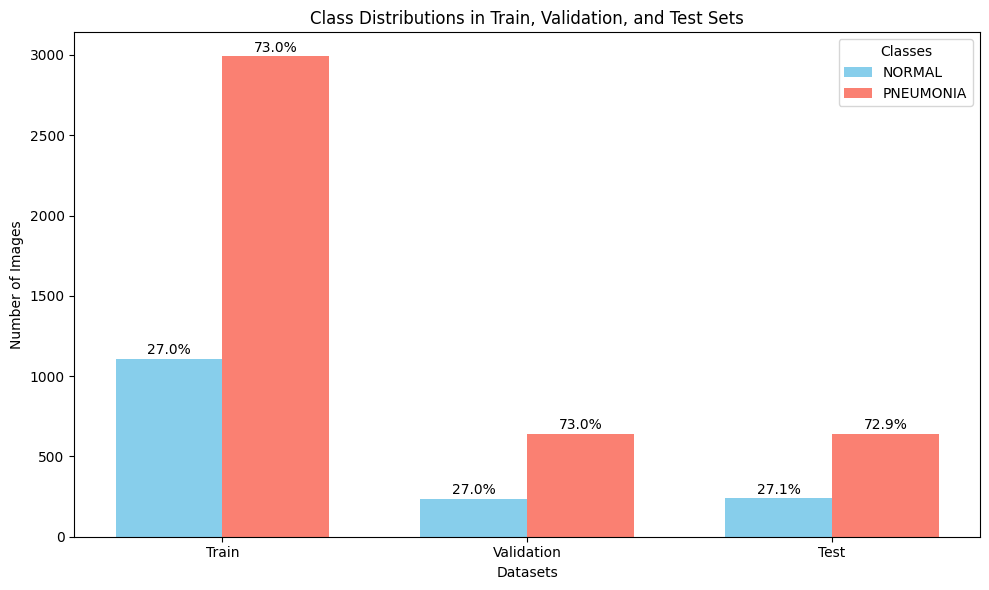

In [7]:
# Function to count images per class using PyTorch ImageFolder
def count_images_per_class(directory):
    dataset = datasets.ImageFolder(directory)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

# Count images in redistributed datasets
redistributed_train_counts = count_images_per_class(redistributed_train_dir)
redistributed_val_counts = count_images_per_class(redistributed_val_dir)
redistributed_test_counts = count_images_per_class(redistributed_test_dir)

# Print class distributions
print("Train Class Distribution:", redistributed_train_counts)
print("Validation Class Distribution:", redistributed_val_counts)
print("Test Class Distribution:", redistributed_test_counts)

# Visualization
datasets = ['Train', 'Validation', 'Test']
class_labels = list(redistributed_train_counts.keys())  # Dynamically get class labels

# Prepare data for plotting
data = [
    [redistributed_train_counts[class_labels[0]], redistributed_train_counts[class_labels[1]]],
    [redistributed_val_counts[class_labels[0]], redistributed_val_counts[class_labels[1]]],
    [redistributed_test_counts[class_labels[0]], redistributed_test_counts[class_labels[1]]],
]

# Plot bar chart
x = range(len(datasets))
bar_width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, [d[0] for d in data], width=bar_width, label=class_labels[0], color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], [d[1] for d in data], width=bar_width, label=class_labels[1], color='salmon')

# Add percentage labels on top of the bars
totals = [sum(d) for d in data]
for i, bars in enumerate([bars1, bars2]):  # Loop through class-wise bars
    for bar, count in zip(bars, [d[i] for d in data]):
        percent = (count / totals[bars.index(bar)]) * 100  # Calculate percentage
        # Place percentage labels clearly above the bars
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{percent:.1f}%',
                 ha='center', fontsize=10, color='black', va='bottom')

# Add labels and title
plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Class Distributions in Train, Validation, and Test Sets')
plt.xticks([i + bar_width / 2 for i in x], datasets)
plt.legend(title="Classes")
plt.tight_layout()
plt.show()


## 4. Basic Data Exploration

#### <b> 4.1. Displaying Sample Images from Redistributed Dataset

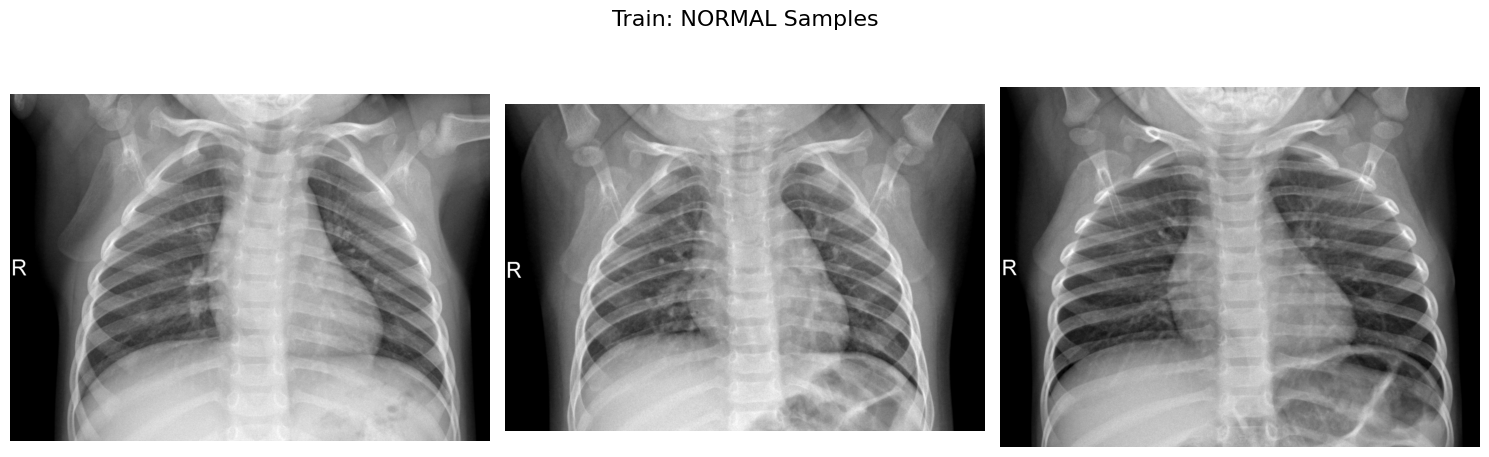

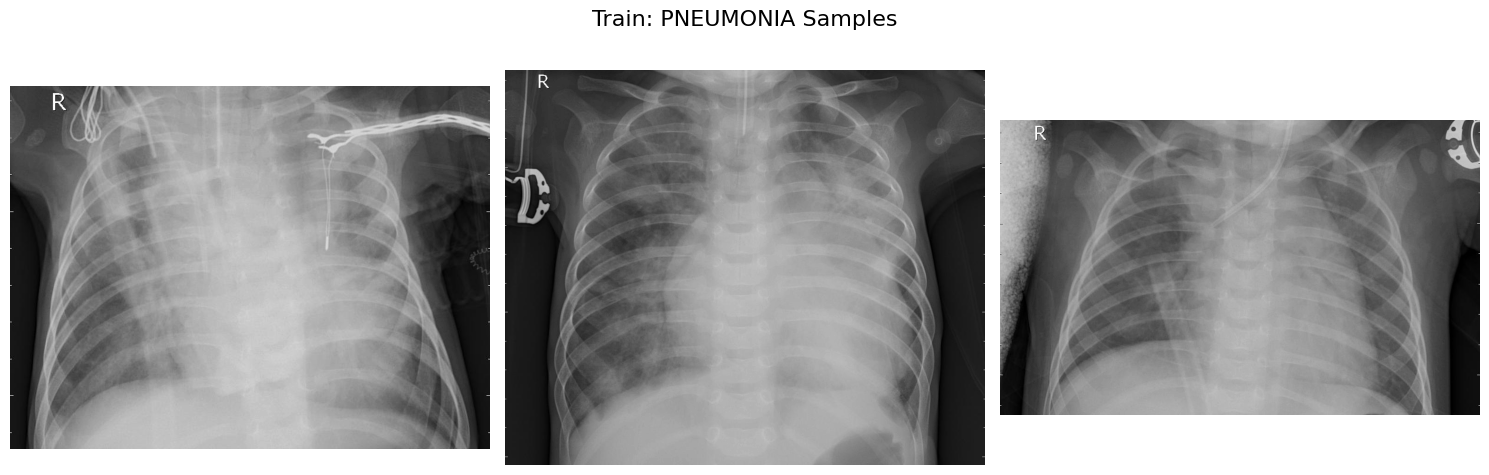

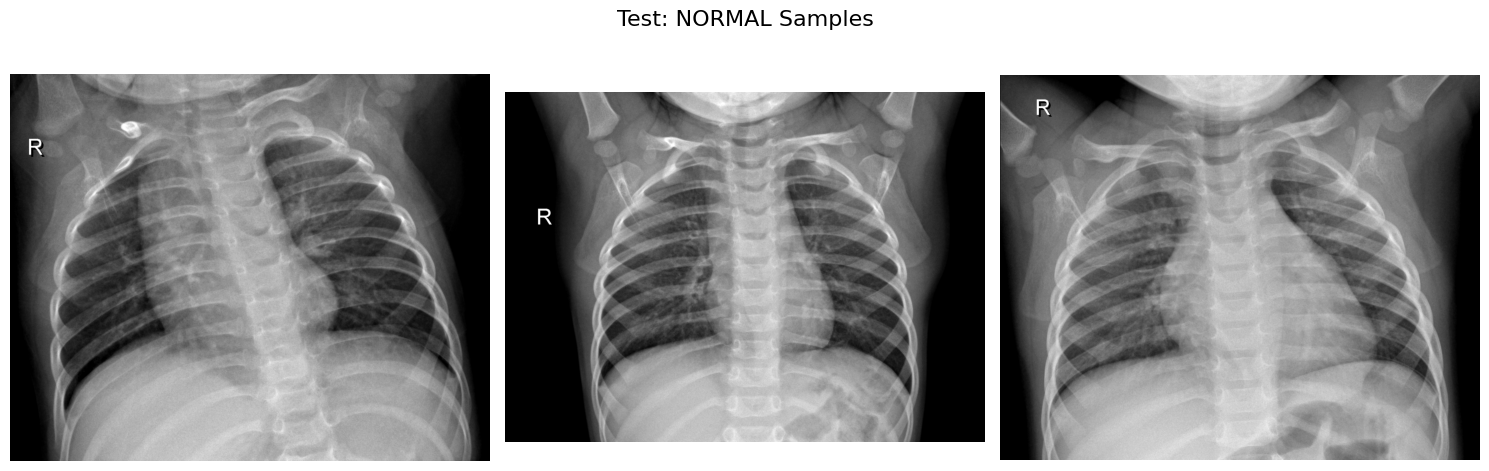

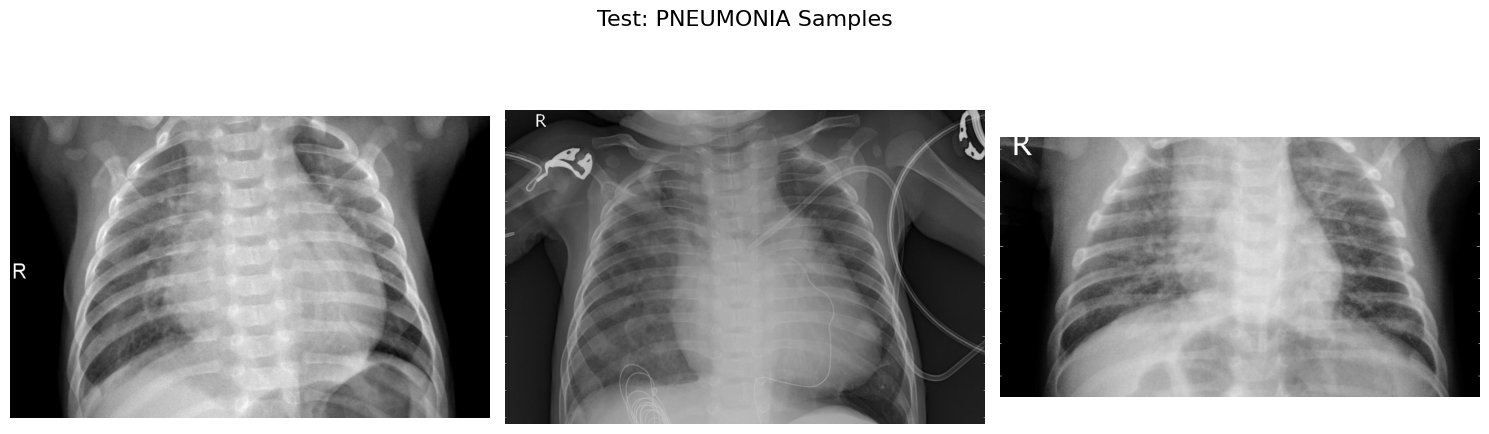

In [8]:
# Function to get image file paths from a specific class
def get_sample_images(directory, class_name, num_samples=3):
    class_dir = os.path.join(directory, class_name)
    image_files = os.listdir(class_dir)
    sample_files = image_files[:num_samples]  # Take the first few images
    return [os.path.join(class_dir, file) for file in sample_files]

# Get samples from train and test datasets
train_normal_samples = get_sample_images(redistributed_train_dir, 'NORMAL', 3)
train_pneumonia_samples = get_sample_images(redistributed_train_dir, 'PNEUMONIA', 3)
test_normal_samples = get_sample_images(redistributed_test_dir, 'NORMAL', 3)
test_pneumonia_samples = get_sample_images(redistributed_test_dir, 'PNEUMONIA', 3)

# Function to display images
def display_images(image_paths, title, rows=1, cols=3):
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths):
        img = Image.open(image_path)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display samples
display_images(train_normal_samples, "Train: NORMAL Samples")
display_images(train_pneumonia_samples, "Train: PNEUMONIA Samples")
display_images(test_normal_samples, "Test: NORMAL Samples")
display_images(test_pneumonia_samples, "Test: PNEUMONIA Samples")

#### <b> 4.2. Calculating Average Image Sizes for Dataset Classes

In [9]:
# Function to calculate average image sizes for classes
def get_image_sizes(directory):
    sizes = {}
    for cls in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(directory, cls)
        image_sizes = []
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            with Image.open(img_path) as img:  # Open the image using PIL
                img_size = img.size  # Returns (width, height)
                image_sizes.append(img_size)
        
        # Calculate the average width and height for the class
        avg_width = sum([size[0] for size in image_sizes]) // len(image_sizes)
        avg_height = sum([size[1] for size in image_sizes]) // len(image_sizes)
        sizes[cls] = (avg_width, avg_height)
    return sizes


# Get average image sizes for each dataset
redistributed_train_sizes = get_image_sizes(redistributed_train_dir)
redistributed_val_sizes = get_image_sizes(redistributed_val_dir)
redistributed_test_sizes = get_image_sizes(redistributed_test_dir)

# Print average image sizes for each dataset
print("Average Image Sizes for Train, Validation, and Test Sets:")
print(f"Training Set - NORMAL: {redistributed_train_sizes['NORMAL']}, PNEUMONIA: {redistributed_train_sizes['PNEUMONIA']}")
print(f"Validation Set - NORMAL: {redistributed_val_sizes['NORMAL']}, PNEUMONIA: {redistributed_val_sizes['PNEUMONIA']}")
print(f"Test Set - NORMAL: {redistributed_test_sizes['NORMAL']}, PNEUMONIA: {redistributed_test_sizes['PNEUMONIA']}")


Average Image Sizes for Train, Validation, and Test Sets:
Training Set - NORMAL: (1683, 1376), PNEUMONIA: (1193, 817)
Validation Set - NORMAL: (1671, 1352), PNEUMONIA: (1188, 818)
Test Set - NORMAL: (1712, 1415), PNEUMONIA: (1208, 830)


#### <b> 4.3. Analyzing Pixel Intensity Distribution for Dataset Classes

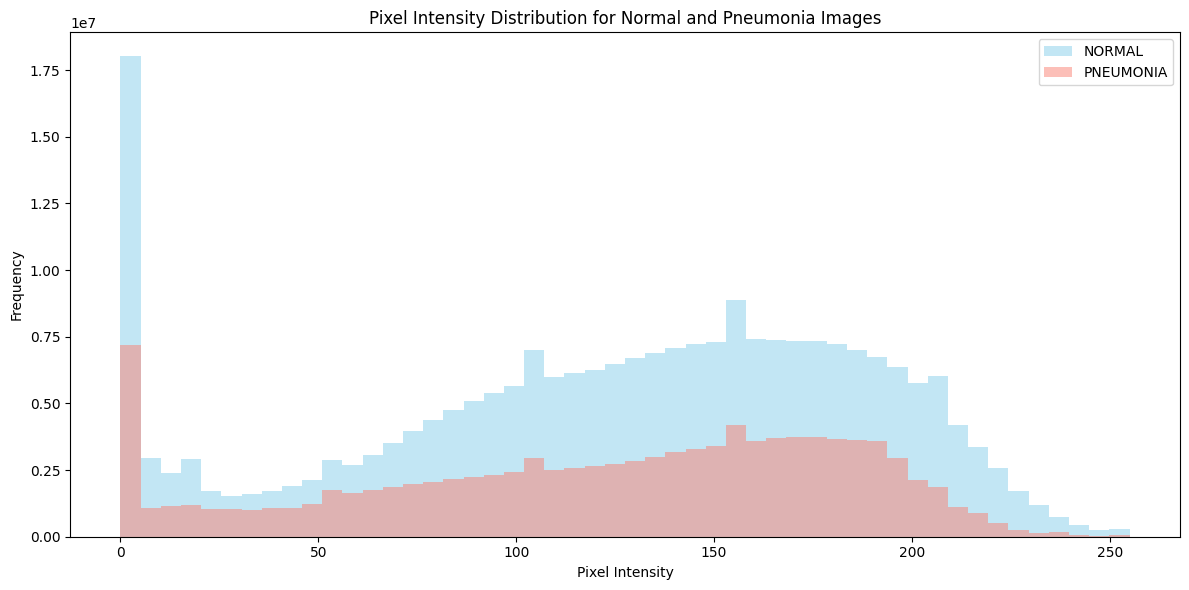

In [10]:
# Function to extract pixel data from sample images
def extract_pixel_data(directory, class_name, sample_size=100):
    class_dir = os.path.join(directory, class_name)
    image_paths = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]
    pixel_values = []
    
    for img_path in image_paths[:sample_size]:  # Take a subset of images
        with Image.open(img_path) as img:
            img = img.convert('L')  # Convert to grayscale for simplicity
            img_array = np.array(img)  # Convert to numpy array
            pixel_values.append(img_array.flatten())  # Flatten the array into 1D
        
    return np.concatenate(pixel_values)  # Concatenate all pixel values

# Extract pixel data for Normal and Pneumonia
normal_pixel_data = extract_pixel_data(redistributed_train_dir, 'NORMAL')
pneumonia_pixel_data = extract_pixel_data(redistributed_train_dir, 'PNEUMONIA')

# Plot the histograms of pixel values
plt.figure(figsize=(12, 6))

# Plot histogram for NORMAL class
plt.hist(normal_pixel_data, bins=50, alpha=0.5, label='NORMAL', color='skyblue')

# Plot histogram for PNEUMONIA class
plt.hist(pneumonia_pixel_data, bins=50, alpha=0.5, label='PNEUMONIA', color='salmon')

# Adding labels and title
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution for Normal and Pneumonia Images')
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


## 5. Data Transformation and Augmentation

#### <b> 5.1. Data Augmentation and DataLoader Setup for Training, Validation, and Testing

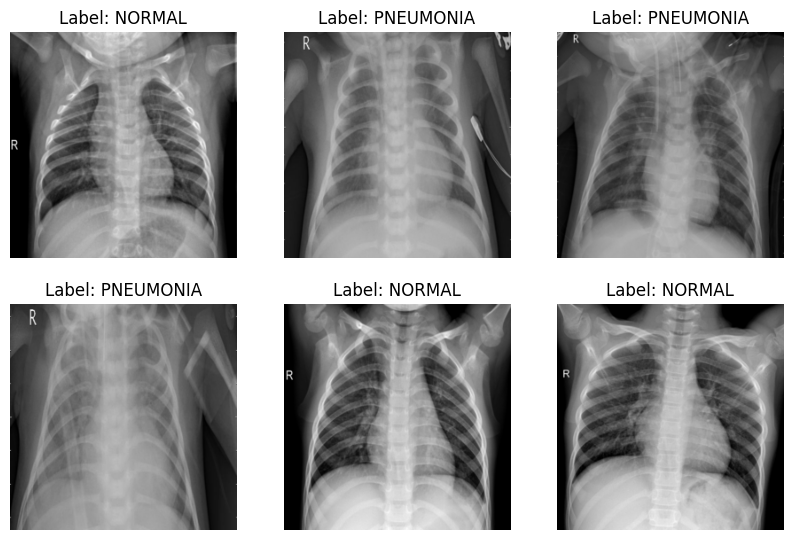

In [11]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize both width and height to 256
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# For test and validation set, use the same transformation
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize both width and height to 256
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = datasets.ImageFolder(root=redistributed_train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=redistributed_val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(root=redistributed_test_dir, transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Display a few augmented images
def display_augmented_images(data_loader, class_names, num_images=6):
    # Get a batch of images
    images, labels = next(iter(data_loader))
    
    # Denormalize images for visualization
    images = images / 2 + 0.5  # Convert from [-1, 1] to [0, 1]

    # Plot a few images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC
        plt.axis('off')
        plt.title(f"Label: {class_names[labels[i]]}")
    plt.show()

# Class names for the labels
class_names = train_dataset.classes  # ['NORMAL', 'PNEUMONIA']

# Display augmented images from the training set
display_augmented_images(train_loader, class_names, num_images=6)

#### <b> 5.2. Checking Image Dimensions After Transformations (train_loader)

In [12]:
# Function to print image dimensions after transformation (Resizing, etc.)
def print_image_dimensions_after_transformation(data_loader):
    # Get a batch of transformed images
    images, _ = next(iter(data_loader))

    # Print the shape of the images in the batch (C x H x W)
    print(f"Shape of one batch of images: {images.shape}")
    print(f"Number of images in the batch: {images.shape[0]}")
    print(f"Image dimensions (C x H x W): {images.shape[1]} x {images.shape[2]} x {images.shape[3]}")

# Print dimensions of the images after transformation for the training set
print_image_dimensions_after_transformation(train_loader)

Shape of one batch of images: torch.Size([32, 3, 256, 256])
Number of images in the batch: 32
Image dimensions (C x H x W): 3 x 256 x 256


#### <b> 5.3. Calculating Class Weights for Imbalanced Dataset

In [13]:
# Calculate class weights for the imbalance
class_counts = {'NORMAL': 1108, 'PNEUMONIA': 2991}  # Train class distribution
class_labels = ['NORMAL', 'PNEUMONIA']

# Compute class weights using sklearn's compute_class_weight method
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=np.array([0] * class_counts['NORMAL'] + [1] * class_counts['PNEUMONIA']))
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).cuda()

# Print out the class weights
print(f"Class weights: {class_weights_tensor}")

Class weights: tensor([1.8497, 0.6852], device='cuda:0')


## 6. ResNet50 model implementation

#### <b> 6.1 ResNet-50 model with pretrained weights

In [14]:
# Define ResNet-50 model with pretrained weights
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.model = models.resnet50(pretrained=True)  # Load pre-trained ResNet50
        num_ftrs = self.model.fc.in_features  # Get the number of input features for the final layer
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Replace FC layer for binary classification

    def forward(self, x):
        return self.model(x)

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Classifier(num_classes=2).to(device)

# Define loss function (weighted cross-entropy) and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s]


#### <b> 6.2 ResNet-50 Training

In [15]:
# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0
model_save_path = "resnet50_best_weights.pth"  # Path to save the best model

# Training and validation loop
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation phase
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), model_save_path)  # Save the best model
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break



Epoch 1/50 - Train Loss: 0.2311, Train Acc: 0.9144 - Val Loss: 0.8219, Val Acc: 0.7369
Epoch 2/50 - Train Loss: 0.1572, Train Acc: 0.9471 - Val Loss: 0.1200, Val Acc: 0.9556
Epoch 3/50 - Train Loss: 0.1328, Train Acc: 0.9475 - Val Loss: 0.2453, Val Acc: 0.9226
Epoch 4/50 - Train Loss: 0.1158, Train Acc: 0.9578 - Val Loss: 0.6742, Val Acc: 0.7722
Epoch 5/50 - Train Loss: 0.1278, Train Acc: 0.9541 - Val Loss: 0.6006, Val Acc: 0.8109
Epoch 6/50 - Train Loss: 0.0924, Train Acc: 0.9673 - Val Loss: 0.2455, Val Acc: 0.9112
Epoch 7/50 - Train Loss: 0.1097, Train Acc: 0.9583 - Val Loss: 0.0851, Val Acc: 0.9681
Epoch 8/50 - Train Loss: 0.0921, Train Acc: 0.9678 - Val Loss: 0.1793, Val Acc: 0.9294
Epoch 9/50 - Train Loss: 0.0685, Train Acc: 0.9722 - Val Loss: 0.1484, Val Acc: 0.9419
Epoch 10/50 - Train Loss: 0.0579, Train Acc: 0.9773 - Val Loss: 0.1299, Val Acc: 0.9579
Epoch 11/50 - Train Loss: 0.1187, Train Acc: 0.9610 - Val Loss: 0.0912, Val Acc: 0.9647
Epoch 12/50 - Train Loss: 0.0743, Train A

#### <b> 6.4. Saving the Model and Training History

/tmp/ipykernel_23/2112947998.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


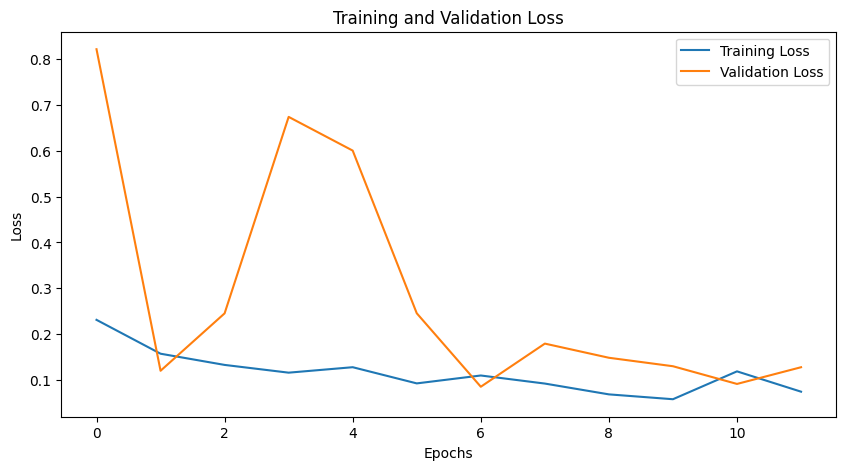

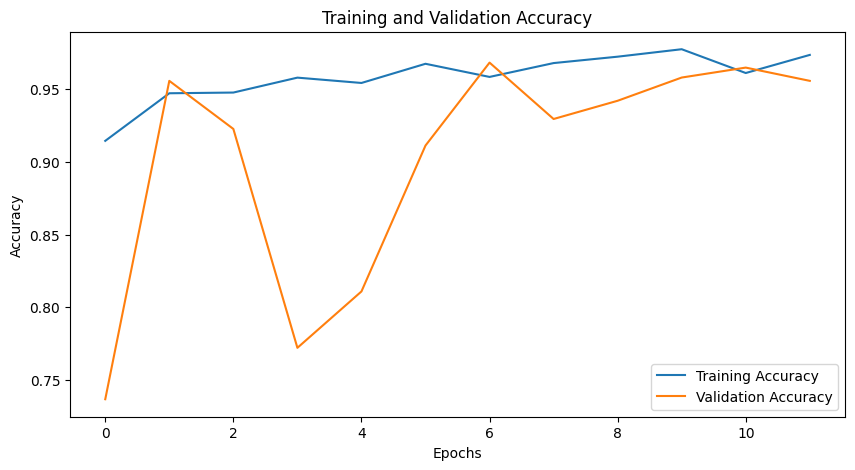

In [16]:
# Load the best model weights
model.load_state_dict(torch.load(model_save_path))

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## 7. Loading the Best Model for Inference

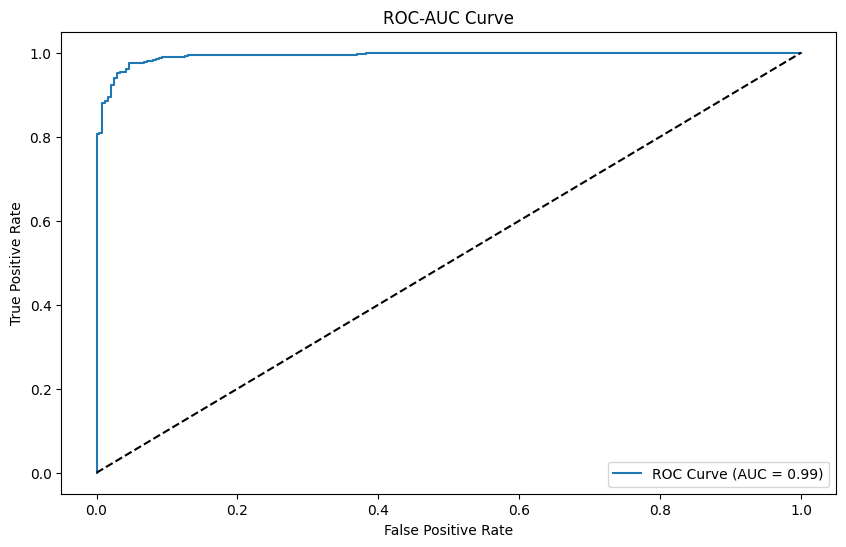

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.91      0.94       238
   PNEUMONIA       0.97      0.99      0.98       641

    accuracy                           0.97       879
   macro avg       0.97      0.95      0.96       879
weighted avg       0.97      0.97      0.97       879



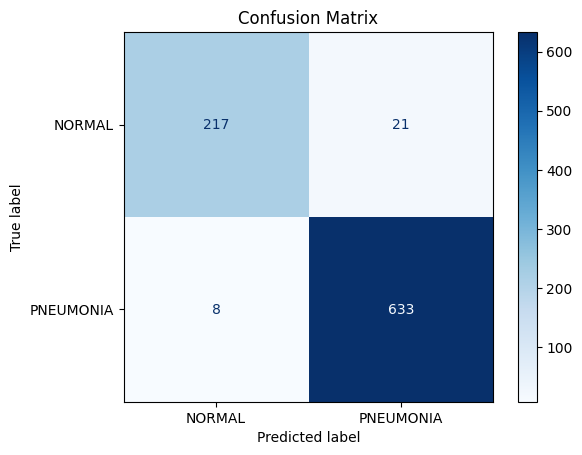

In [17]:
# Test inference and ROC-AUC
model.eval()
y_true, y_pred, y_scores = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())

# ROC-AUC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=class_names, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## 8. Testing the Model and Visualizing Predictions

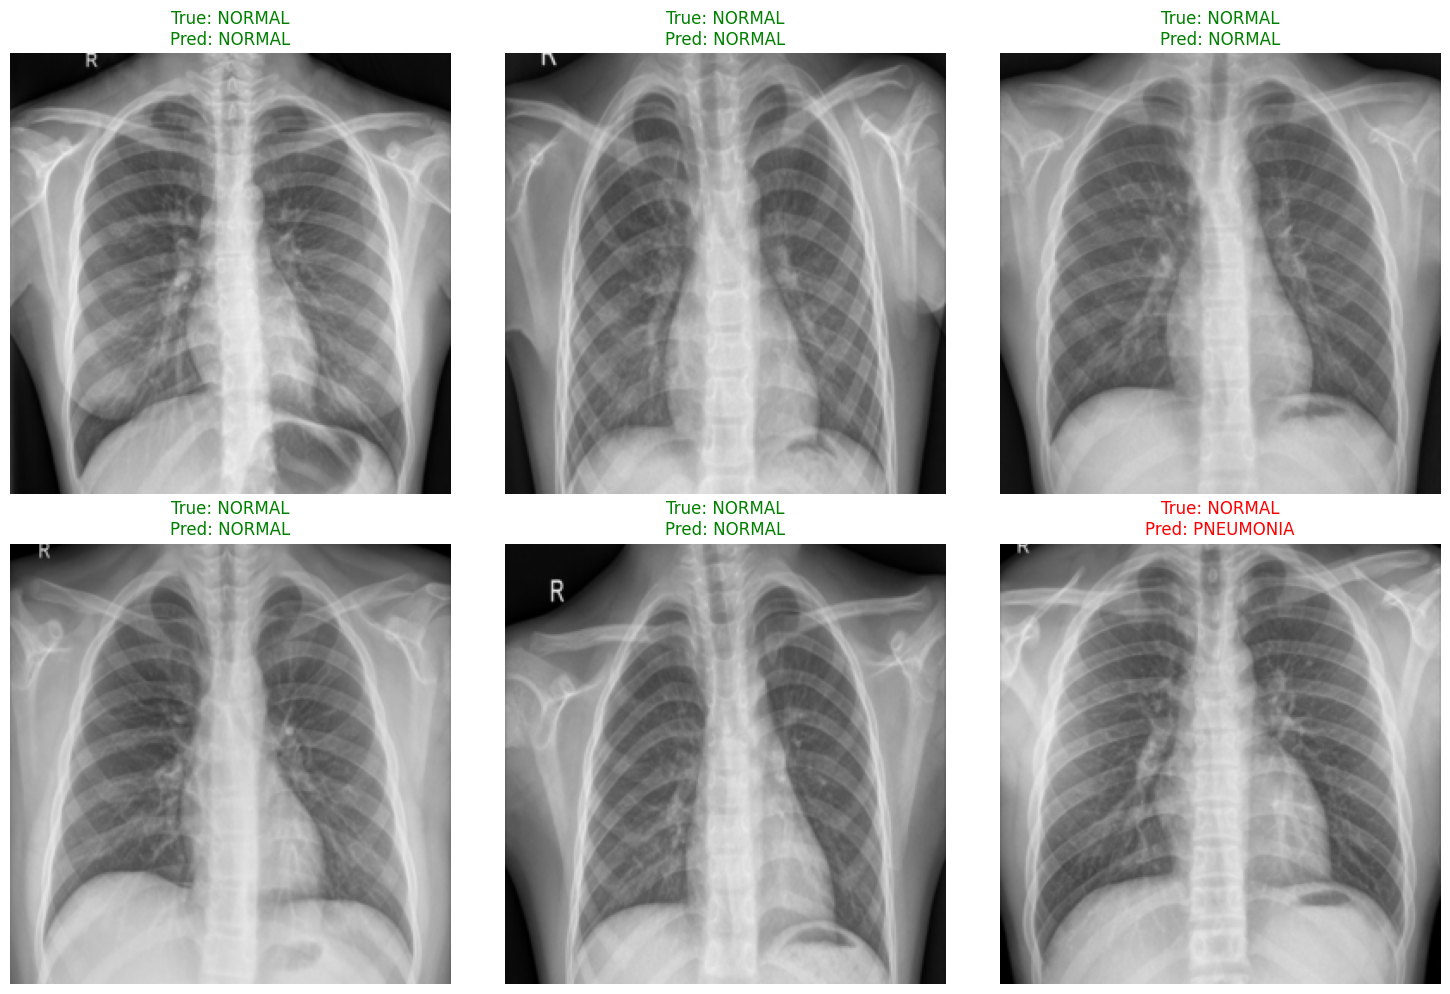

In [18]:
def display_predictions(data_loader, model, class_names, num_images=6, device='cuda'):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Denormalize images for visualization
    denorm = transforms.Normalize((-1, -1, -1), (2, 2, 2))  # Inverse of normalization
    images = denorm(images.cpu())

    # Plot images with predictions
    plt.figure(figsize=(15, 10))
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).clamp(0, 1))  # Convert CHW to HWC and clamp values
        plt.axis('off')
        true_label = class_names[labels[i].cpu()]
        predicted_label = class_names[preds[i].cpu()]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color="green" if true_label == predicted_label else "red")
    plt.tight_layout()
    plt.show()

# Call the function to display predictions
display_predictions(test_loader, model, class_names, num_images=6)